In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import missingno as msno
import seaborn as sns
import scipy as sc

from sklearn.utils import shuffle

df = pd.read_excel(open('datazone.xlsx','rb'))

# Nettoyage des données 

Ce notebook effectue une analyse statistique, un nettoyage des données, et un traitement de la variable "pays d'origine"
On renvoie un nouveau dataframe, plus propre

In [2]:
def plot_value_counts(col_name,df):       
    
    values_count = pd.DataFrame(df[col_name].dropna().value_counts())
    print (values_count.shape)
    values_count.columns = ['count']
    # convert the index column into a regular column.
    values_count[col_name] = [ str(i) for i in values_count.index ]
    # add a column with the percentage of each data point to the sum of all data points.
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2)
    # change the order of the columns.
    values_count = values_count.reindex([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True)
    return (values_count)

In [3]:
# mélanger les données

df = shuffle(df)

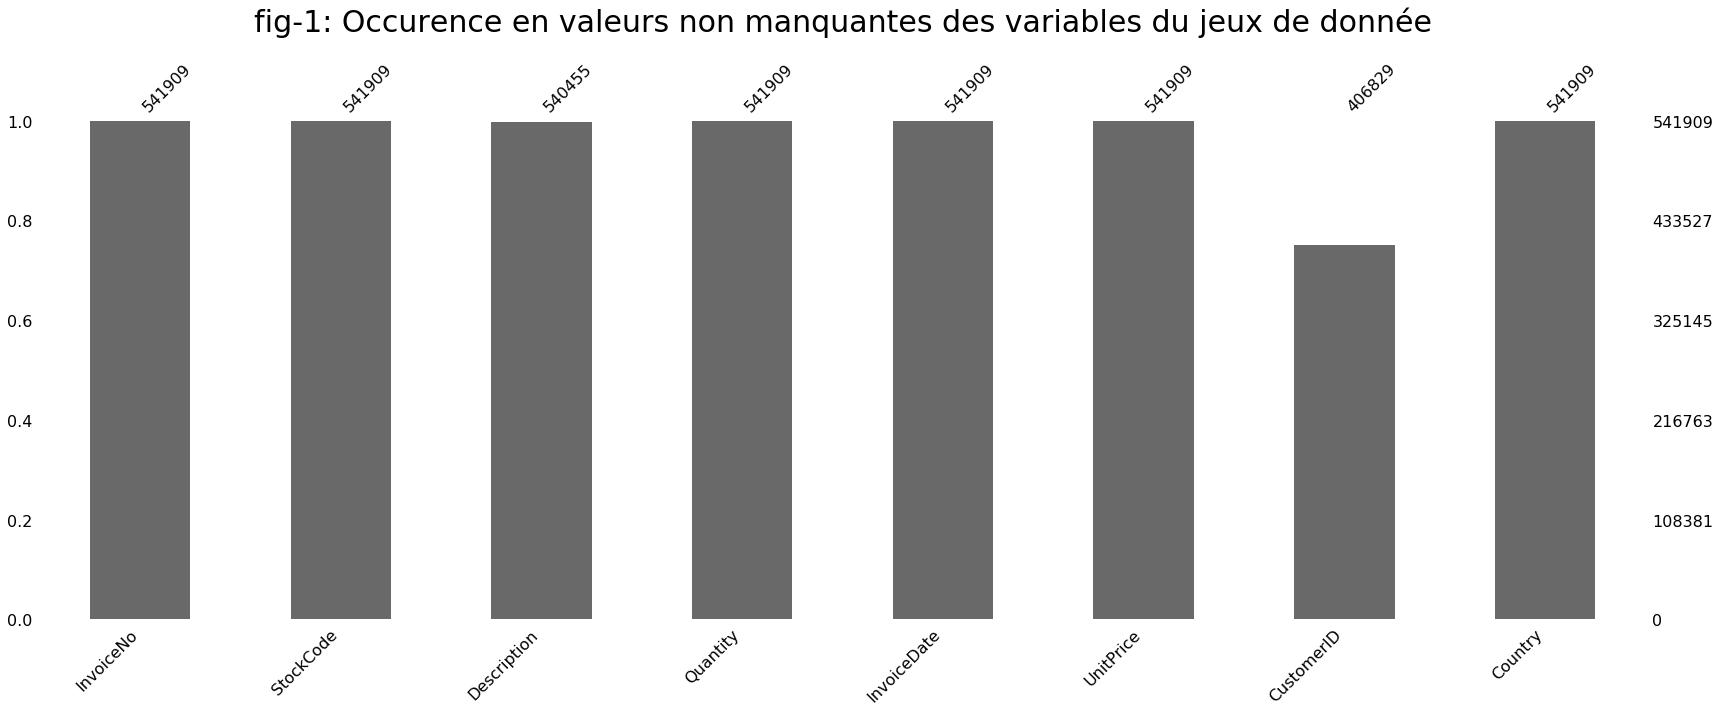

In [4]:
# visualisation des données
mat = msno.bar(df)
mat.axes.get_xaxis().set_visible(True)
mat.axes.get_yaxis().set_visible(True)
plt.title('fig-1: Occurence en valeurs non manquantes des variables du jeux de donnée',fontsize=30,loc='center', pad = 90)
plt.tight_layout(h_pad=2)
plt.savefig('occurences.png', dpi=400)

In [5]:
# supprimons les exemples contenants des valeurs manquantes à l'exception de customer ID 
print ("dimension avant suppression des valeurs manquantes")
print(df.shape)
df = df.dropna(0,how='any',subset =['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice', 'Country'])
print ("dimension après suppression des valeurs manquantes")
print(df.shape)


dimension avant suppression des valeurs manquantes
(541909, 8)
dimension après suppression des valeurs manquantes
(540455, 8)


In [6]:
df1 = df.copy()

In [4]:
# dimension 
print (df.shape)
# visualisation des variables
print (df.columns[:])

(541909, 8)
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


Nous cherchons à visualiser le nombre d'utilisateur ainsi que le nombre de commande associé à chaque utilisateur

(3958, 1)
nombre d'utilisateurs
3958


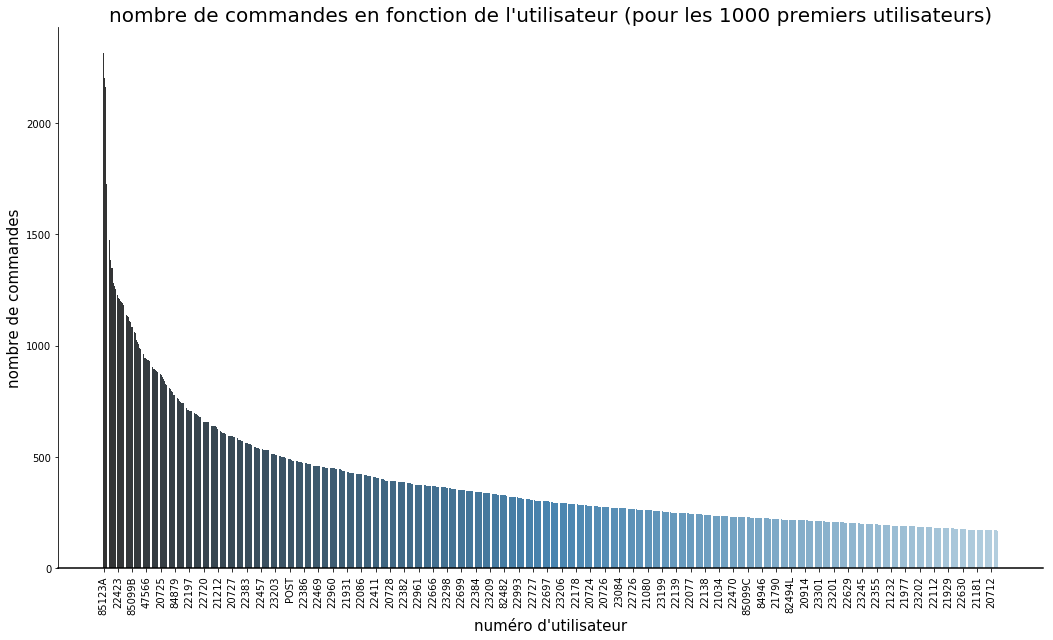

In [8]:
valeurs = plot_value_counts('StockCode',df=df)
print ("nombre d'utilisateurs")
print (valeurs.shape[0])


# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)

# occurence en valeurs non manquantes
y1 = valeurs.iloc[0:1000,1]
g = sns.barplot(x=valeurs.iloc[0:1000,0], y=y1, palette='Blues_d', ax=ax1)
ax1.axhline(0, color="k", clip_on=False)

# affiche uniquement un certain nombre de films en légende
plt.locator_params(axis='x', nbins=65)
#ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlabel("numéro d'utilisateur",fontsize=15)
ax1.set_ylabel("nombre de commandes",fontsize=15)
#plt.axis([0, 365, 0, 40])

# Finalize the plot
g = sns.despine(bottom=True)
plt.xticks(rotation=90)
plt.title("nombre de commandes en fonction de l'utilisateur (pour les 1000 premiers utilisateurs)",fontsize=20)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.savefig('fig_commandes_utilisateurs.png', dpi=400)

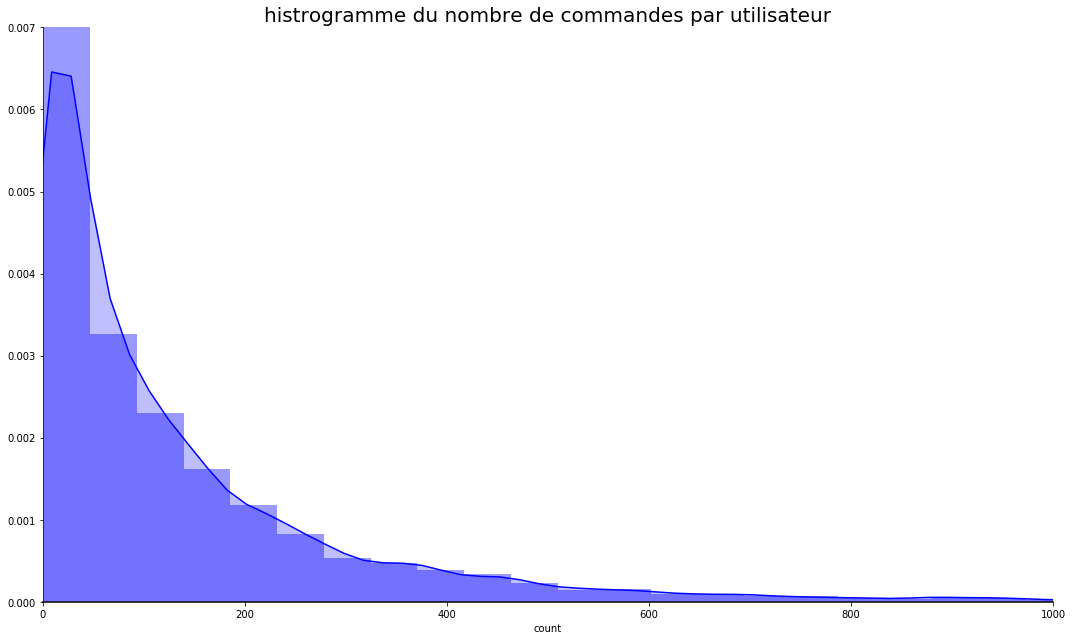

In [24]:
# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)

# Plot a filled kernel density estimate
sns.distplot(valeurs.iloc[:,1],  hist=True, color="b", kde_kws={"shade": True})

ax1.axhline(0, color="k", clip_on=False)

# affiche uniquement un certain nombre de films en légende
#plt.locator_params(axis='x', nbins=65)
#ax1.axes.get_xaxis().set_visible(False)
#ax1.set_xlabel("numéro d'utilisateurs",fontsize=15)
#ax1.set_ylabel("nombre de commandes",fontsize=15)
plt.axis([0, 1000, 0, 0.007])

# Finalize the plot
g = sns.despine(bottom=True)
#plt.xticks(rotation=90)
plt.title("histrogramme du nombre de commandes par utilisateur",fontsize=20)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.savefig('fig_commandes_hist.png', dpi=400)



Nous cherchons maintenant à visualiser le nombre d'unités de commandes par commande

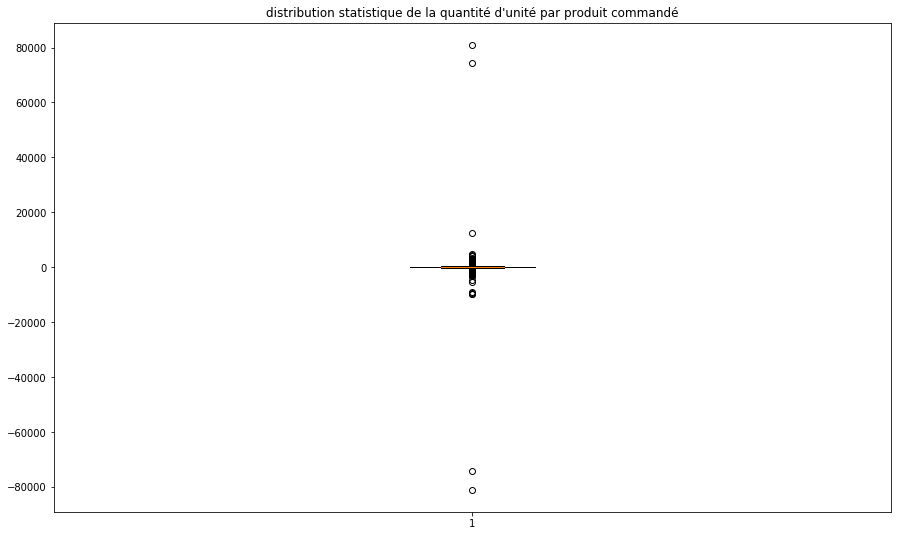

In [16]:
# visualisons la distribution via boxplot
# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)
#plt.hist(df.loc[:, 'UnitPrice'], bins=1000, color='black',
       # normed=True, edgecolor='none')
plt.title("distribution statistique de la quantité d'unité par produit commandé", fontsize=12)
ax1.boxplot(df.loc[:,'Quantity'],whis=30,notch=True)
#plt.axis([-100, 100, 0, 0.006])
# plt.setp(f.axes, yticks=[])
# plt.tight_layout(h_pad=2)
plt.savefig('pict_boxplot_quantity', dpi=400)

In [19]:
# pourcentage de valeurs négatives 
print ((df[df.loc[:,'Quantity']<0].shape[0]/df.shape[0])*100)

1.8062558399866777


Nous notons de valeurs potentiellement aberrantes et des valeurs négatives qui n'ont pas de sens 

Nous pouvons supposer que ces valeurs correspondent à des annulations de clients.
Cela est conforté par la distribution statistique précédente qui semble relativement symétrique entre les négatifs et les positifs. Deux possibilités s'offrent à nous, nous pouvons garder ces informations et définir une nouvelle variable "nombre d'annulation" caractérisant la propension d'un utilisateur à annuler où pas. Cependant les annulations ne représentent, d'une part que moins de 2% des transactions, et d'autre part nous considérons que l'interet pour l'entreprise de segmenter les clients en fonction de ceux ayant tendance à annuler de deux qui annulent jamais est faible.
De ce fait, nous choisissons de supprimer ces transactions ainsi que leurs penchants positifs. 

In [21]:
df_cancelled = df[df.loc[:,'Quantity']<0]
# annuler les transactions positives
print (df.shape)
for i in range (df_cancelled.shape[0]): 
    print (i)
    df = df[(df.iloc[:,1]!=df_cancelled.iloc[i,1])|
                       (df.iloc[:,2]!=df_cancelled.iloc[i,2])|(df.iloc[:,3]!=(-df_cancelled.iloc[i,3]))|
                       (df.iloc[:,5]!=df_cancelled.iloc[i,5])|(df.iloc[:,6]!=df_cancelled.iloc[i,6])|
                       (df.iloc[:,7]!=df_cancelled.iloc[i,7])]
print (df.shape)    
# annuler les transactions négatives ou nulles 
df = df[df.loc[:,'Quantity']>0]

    
    



(540455, 8)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
27

1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058


3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697


5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336


6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810


KeyboardInterrupt: 

In [69]:
print (df.shape)

(526128, 8)


Visualisons les valeurs extrémes 

In [70]:
df_extreme = df[df.loc[:,'Quantity']>1000]
print (df_extreme.shape)
print (df_extreme)

(105, 8)
       InvoiceNo StockCode                          Description  Quantity  \
348316    567423     23286             BLUE VINTAGE SPOT BEAKER      1878   
52134     540689     22470                HEART OF WICKER LARGE      1284   
177702    552172     16014          SMALL CHINESE STYLE SCISSOR      2000   
490502    578060         M                               Manual      1600   
540070    581458     22197                       POPCORN HOLDER      1500   
376061    569492     21915               RED  HARMONICA IN BOX       1540   
467796    576365     22197                       POPCORN HOLDER      1130   
321040    565122     84568      GIRLS ALPHABET IRON ON PATCHES       1440   
16435     537659     22189              CREAM HEART CARD HOLDER      1008   
437478    574294     22086      PAPER CHAIN KIT 50'S CHRISTMAS       1020   
289952    562343     22616           PACK OF 12 LONDON TISSUES       1008   
540071    581459     22197                       POPCORN HOLDER    

Tous ces exemples nous semblent contenir des incohérences : prix à l'unité de 0, commandes en doublon à quelques minutes de différence... (nous préférons nous en séparer)

In [71]:
# supprimer les prix négatifs ou nul : 
print ('dimension avant')
print (df.shape)
df = df[df.loc[:,'UnitPrice']>0]
print ('dimension après')
print (df.shape)

dimension avant
(526128, 8)
dimension après
(524947, 8)


dimension avant
(524947, 8)
dimension après
(524947, 8)


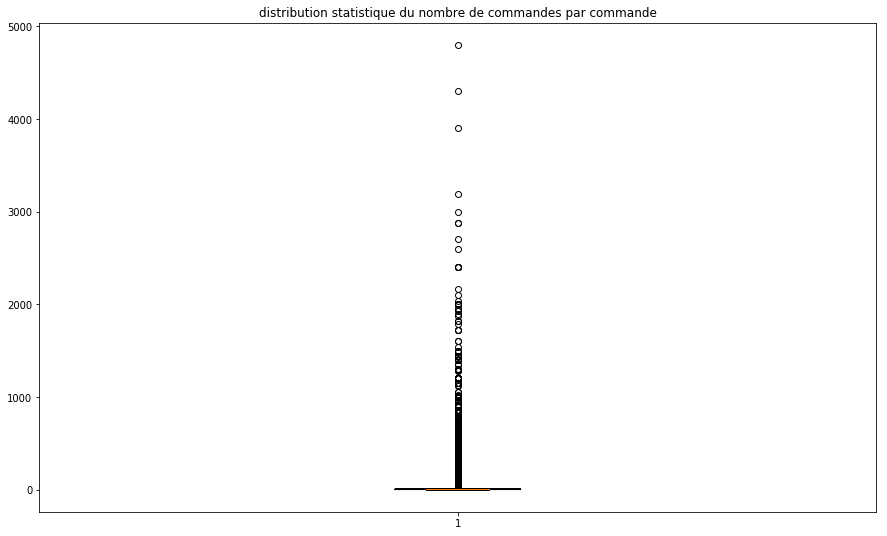

In [72]:
# supprimer les valeurs supérieures à 7000 unités par commande 
print ('dimension avant')
print (df.shape)
df = df[df.loc[:,'Quantity']<7000]
print ('dimension après')
print (df.shape)
# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)
#plt.hist(df.loc[:, 'UnitPrice'], bins=1000, color='black',
       # normed=True, edgecolor='none')
plt.title("distribution statistique de la quantité de produit par produit commandé", fontsize=12)
ax1.boxplot(df.loc[:,'Quantity'],notch=True)
#plt.axis([-100, 100, 0, 0.006])
# plt.setp(f.axes, yticks=[])
# plt.tight_layout(h_pad=2)
plt.savefig('pict_boxplot_quantity', dpi=400)

(366, 1)
nombre d'utilisateurs
366


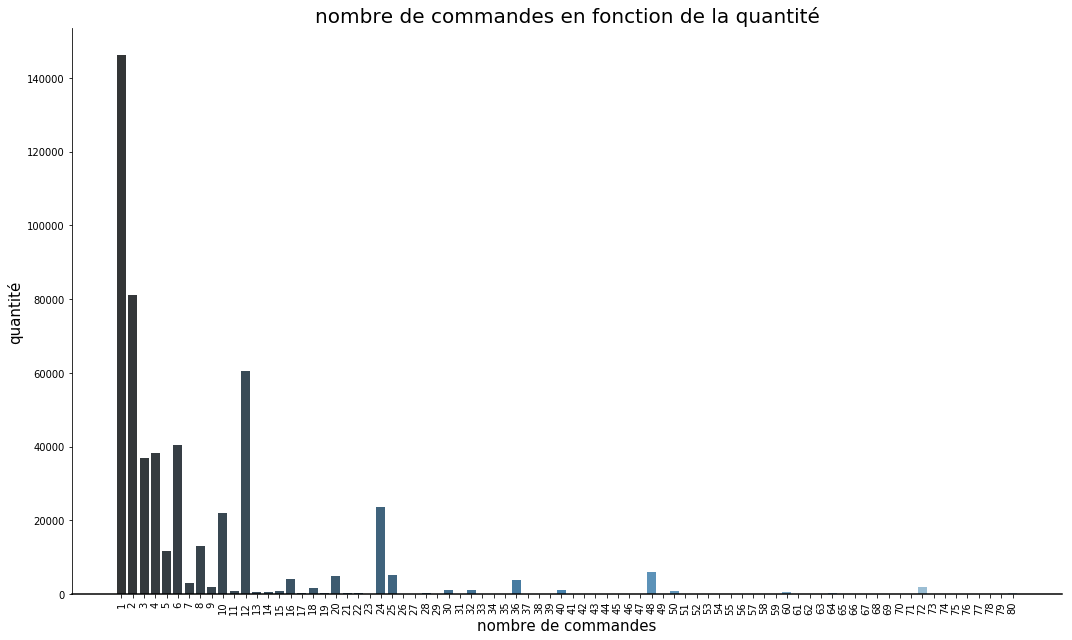

In [73]:
valeurs = plot_value_counts('Quantity',df=df)
print ("nombre d'utilisateurs")
print (valeurs.shape[0])
valeurs.iloc[:,0] = pd.to_numeric(valeurs.iloc[:,0], errors='coerce').fillna(0, downcast='infer')
valeurs = valeurs.sort_values(by=['Quantity'])


# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)

# occurence en valeurs non manquantes
y1 = valeurs.iloc[0:80,1]
g = sns.barplot(x=valeurs.iloc[0:80,0], y=y1, palette='Blues_d', ax=ax1)
ax1.axhline(0, color="k", clip_on=False)

# affiche uniquement un certain nombre de films en légende
plt.locator_params(axis='x', nbins=80)
#ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlabel("nombre de commandes",fontsize=15)
ax1.set_ylabel("quantité",fontsize=15)
#plt.axis([0, 365, 0, 40])

# Finalize the plot
g = sns.despine(bottom=True)
plt.xticks(rotation=90)
plt.title("nombre de transactions en fonction de la quantité",fontsize=20)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.savefig('fig_commandes_quantity.png', dpi=400)

Visualiser la distribution des prix 

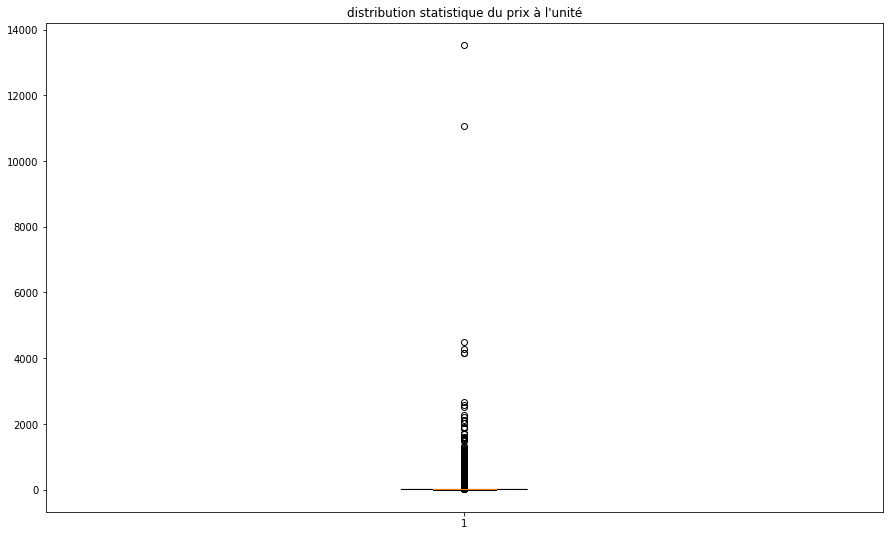

In [74]:
# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)
#plt.hist(df.loc[:, 'UnitPrice'], bins=1000, color='black',
       # normed=True, edgecolor='none')
plt.title("distribution statistique du prix à l'unité", fontsize=12)
ax1.boxplot(df.loc[:,'UnitPrice'],notch=True)
#plt.axis([-100, 100, 0, 0.006])
# plt.setp(f.axes, yticks=[])
# plt.tight_layout(h_pad=2)
plt.savefig('pict_boxplot_price', dpi=400)

In [75]:
# visualiser les valeurs extrèmes : 
print (df[df.loc[:,'UnitPrice']>100])
print (df[df.loc[:,'UnitPrice']>100].shape)


       InvoiceNo  StockCode                         Description  Quantity  \
170674    551339        DOT                      DOTCOM POSTAGE         1   
392440    570690        DOT                      DOTCOM POSTAGE         1   
294497    562715        DOT                      DOTCOM POSTAGE         1   
508459    579196        DOT                      DOTCOM POSTAGE         1   
232891    557377          M                              Manual         1   
30905     538883        DOT                      DOTCOM POSTAGE         1   
114795    546088      22826       LOVE SEAT ANTIQUE WHITE METAL         1   
137804    548167        DOT                      DOTCOM POSTAGE         1   
229969    557112        DOT                      DOTCOM POSTAGE         1   
211678    555397        DOT                      DOTCOM POSTAGE         1   
129995    547399        DOT                      DOTCOM POSTAGE         1   
183597    552663        DOT                      DOTCOM POSTAGE         1   

In [76]:
# on supprimer les éléments AMAZONFEE, MANUAL, DOTCOM POSTAGE, Adjust bad debt, POSTAGE, CRUK Commission, Bank charges, Discount, Samples
print ('dimension avant')
print ('-----------AMAZON FEE-----------')
print (df.shape)
df = df[(df.loc[:,'Description']!='AMAZON FEE')]
print ('dimension après')
print (df.shape)
print ('dimension avant')
print ('-----------Manual-----------')
print (df.shape)
df = df[(df.loc[:,'Description']!='Manual')]
print ('dimension après')
print (df.shape)
print ('dimension avant')
print ('-----------DOTCOM POSTAGE-----------')
print (df.shape)
df = df[(df.loc[:,'Description']!='DOTCOM POSTAGE')]
print ('dimension après')
print (df.shape)
print ('dimension avant')
print ('-----------Adjust bad debt-----------')
print (df.shape)
df = df[(df.loc[:,'Description']!='Adjust bad debt')]
print ('dimension après')
print (df.shape)
print ('dimension avant')
print ('-----------POSTAGE-----------')
print (df.shape)
df = df[(df.loc[:,'Description']!='POSTAGE')]
print ('dimension après')
print (df.shape)
print ('dimension avant')
print ('-----------POSTAGE-----------')
print (df.shape)
df = df[(df.loc[:,'Description']!='POSTAGE')]
print ('dimension après')
print (df.shape)
print ('dimension avant')
print ('-----------CRUK Commission-----------')
print (df.shape)
df = df[(df.loc[:,'Description']!='CRUK Commission')]
print ('dimension après')
print (df.shape)
print ('dimension avant')
print ('-----------Bank Charges-----------')
print (df.shape)
df = df[(df.loc[:,'Description']!='Bank Charges')]
print ('dimension après')
print (df.shape)
print ('-----------Discount-----------')
print (df.shape)
df = df[(df.loc[:,'Description']!='Discount')]
print ('dimension après')
print (df.shape)
print ('-----------Samples-----------')
print (df.shape)
df = df[(df.loc[:,'Description']!='SAMPLES')]
print ('dimension après')
print (df.shape)
print ('-----------PICNIC BASKET WICKER 60 PIECES-----------')
print (df.shape)
df = df[(df.loc[:,'Description']!='PICNIC BASKET WICKER 60 PIECES')]
print ('dimension après')
print (df.shape)


dimension avant
-----------AMAZON FEE-----------
(524947, 8)
dimension après
(524945, 8)
dimension avant
-----------Manual-----------
(524945, 8)
dimension après
(524667, 8)
dimension avant
-----------DOTCOM POSTAGE-----------
(524667, 8)
dimension après
(523961, 8)
dimension avant
-----------Adjust bad debt-----------
(523961, 8)
dimension après
(523960, 8)
dimension avant
-----------POSTAGE-----------
(523960, 8)
dimension après
(522908, 8)
dimension avant
-----------POSTAGE-----------
(522908, 8)
dimension après
(522908, 8)
dimension avant
-----------CRUK Commission-----------
(522908, 8)
dimension après
(522908, 8)
dimension avant
-----------Bank Charges-----------
(522908, 8)
dimension après
(522896, 8)
-----------Discount-----------
(522896, 8)
dimension après
(522896, 8)
-----------Samples-----------
(522896, 8)
dimension après
(522894, 8)
-----------PICNIC BASKET WICKER 60 PIECES-----------
(522894, 8)
dimension après
(522892, 8)


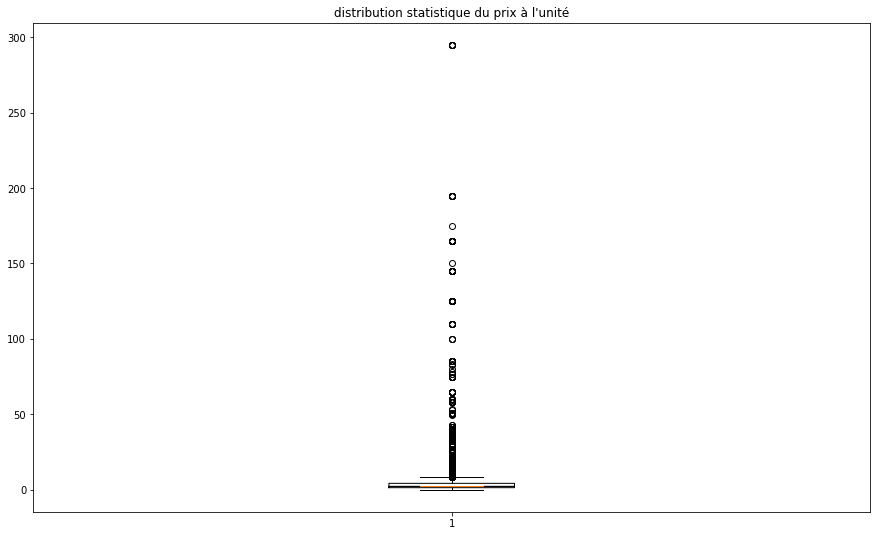

In [77]:
# revisualiser la distribution statistique
# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)
#plt.hist(df.loc[:, 'UnitPrice'], bins=1000, color='black',
       # normed=True, edgecolor='none')
plt.title("distribution statistique du prix à l'unité", fontsize=12)
ax1.boxplot(df.loc[:,'UnitPrice'],notch=True)
#plt.axis([-100, 100, 0, 0.006])
# plt.setp(f.axes, yticks=[])
# plt.tight_layout(h_pad=2)
plt.savefig('pict_boxplot_price', dpi=400)

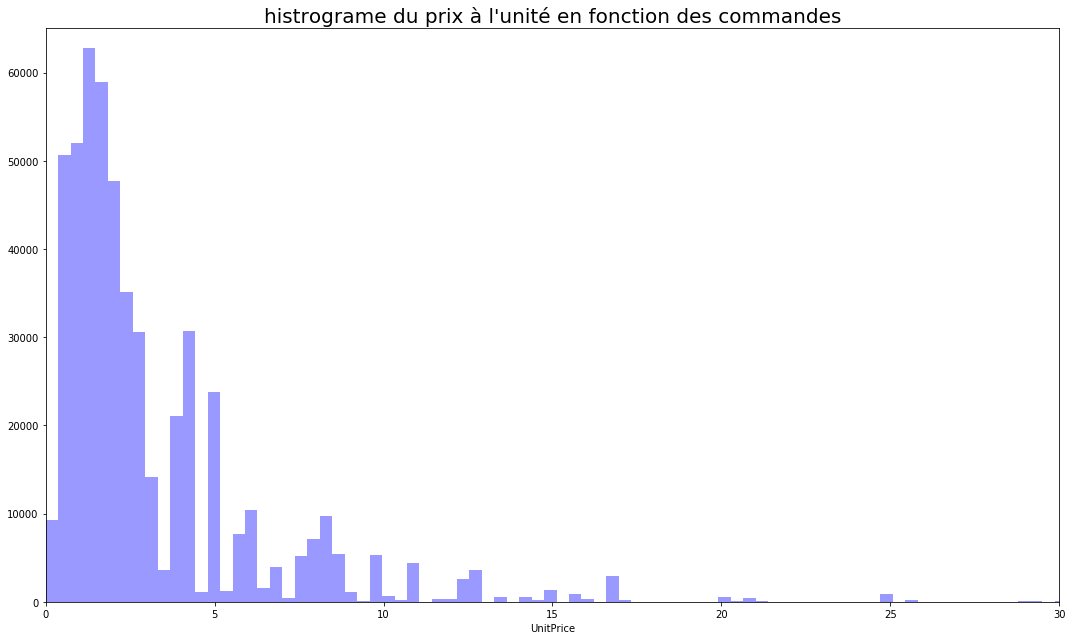

In [78]:
# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)

# Plot a filled kernel density estimate
sns.distplot(df.loc[:,'UnitPrice'],bins=800, kde=False, color="b")

#ax1.axhline(0, color="k", clip_on=False)

# affiche uniquement un certain nombre de films en légende
#plt.locator_params(axis='x', nbins=65)
#ax1.axes.get_xaxis().set_visible(False)
#ax1.set_xlabel("numéro d'utilisateurs",fontsize=15)
#ax1.set_ylabel("nombre de commandes",fontsize=15)
plt.axis([0, 30, 0, 65000])

# Finalize the plot
#g = sns.despine(bottom=True)
#plt.xticks(rotation=90)
plt.title("histrograme du prix à l'unité en fonction des commandes",fontsize=20)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.savefig('fig_price_hist.png', dpi=400)


In [119]:
# on note les différent percentiles (utile dans l'API pour afficher les résultats en nuances de couleur)
q3 = (np.percentile(df.loc[:,'UnitPrice'], 50,interpolation='higher'))
q2 = (np.percentile(df.loc[:,'UnitPrice'], 33.333,interpolation='higher'))
q1 = (np.percentile(df.loc[:,'UnitPrice'], 16.666,interpolation='higher'))
q4 = (np.percentile(df.loc[:,'UnitPrice'], 66.666,interpolation='higher'))
q5 = (np.percentile(df.loc[:,'UnitPrice'], 83.666,interpolation='higher'))
print (q1)
print (q2)
print (q3)
print (q4)
print (q5)



0.85
1.49
2.08
3.29
4.96


Une idée pourait être de générer des nouvelles variables en discrétisant la distribution du prix à l'unité, par exemple en utilisant les quintiles. 

In [79]:
# on rajoute une lettre N (pour number) avant chaque numéro de produit
df.loc[:,'StockCode'] = 'N' + df['StockCode'].astype(str) 
# on rajoute une lettre N (pour number) avant chaque numéro de produit
df.loc[:,'CustomerID'] = 'N' + df['CustomerID'].astype(str) 


les produits ne sont pas toujours vendus au même prix (sans doute le prix variant dans le temps promotions ou s'adapte à l'utilisateur)

visualiser les occurences de chaque pays 

(38, 1)


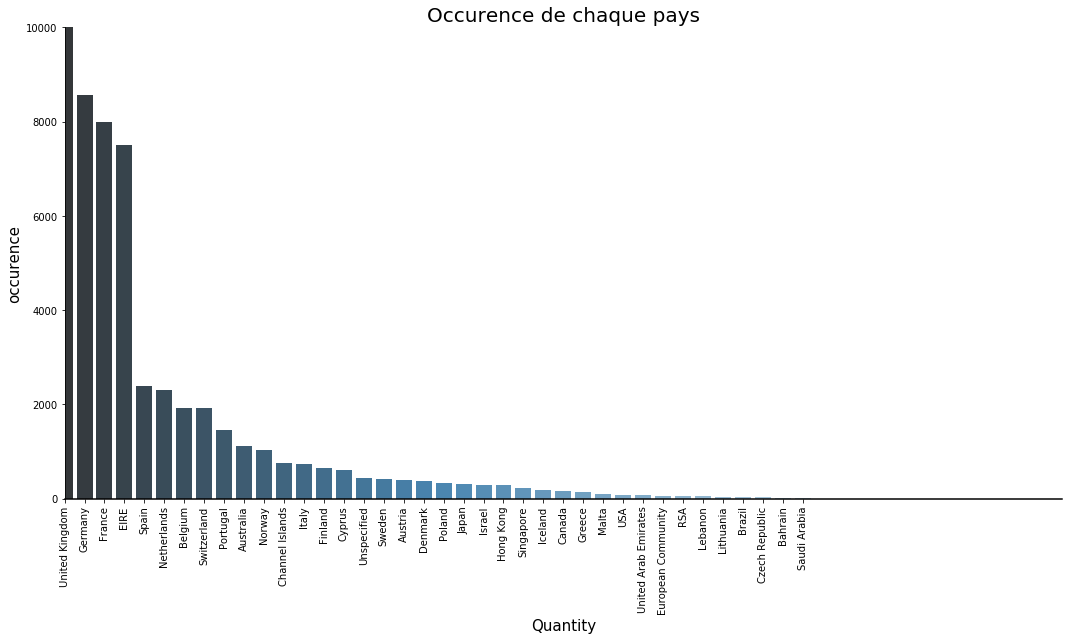

In [80]:
valeurs = plot_value_counts('Country',df=df)
# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)

# occurence en valeurs non manquantes
y1 = valeurs.iloc[:,1]
g = sns.barplot(x=valeurs.iloc[:,0], y=y1, palette='Blues_d', ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Occurence",fontsize=15)
# affiche uniquement un certain nombre de films en légende
plt.locator_params(axis='x', nbins=65)
#ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlabel("Quantity",fontsize=15)
ax1.set_ylabel("occurence",fontsize=15)
plt.axis([0, 50, 0, 10000])

# Finalize the plot
g = sns.despine(bottom=True)
plt.xticks(rotation=90)
plt.title("Occurence de chaque pays",fontsize=20)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.savefig('pict_retard_jour_year.png', dpi=400)

 L'occurence du Royaume-Unis est largement plus importante que celles des autres pays. Nous supposons que la plateforme est basée au Royaume-Unis. De ce fait, il y a une grande différence entre le comportement des acheteurs britaniques qui souhaitent plutôt des produits moins chers, ou des facilité de livraison et les acheteurs étrangers qui cherchent sans doute à se procurer des produits qu'ils n'ont pas dans leurs pays. La nature de ces produits varie en fonction des pays (culture, législation, nature des produits vendus au sein du pays considéré). Trois possibilités se présentent, on peut ne vouloir considérer que les acheteurs britaniques. On peut constituer au contraire une catégorie par pays, cependant certains pays (la majorité) interviennent en occurence tellement faible  que nos modèles ne seront pas à même d'interpréter les phénoménes sous-jacents cités précédemment. On peut vouloir ne travailler avec qu'un petit nombre de pays en imposant une occurence minimum). On peut aussi tenter d'agréger au sein de catégories de pays économiquement/culturellement/sociologiquement identiques ex: pays de l'union européenne de l'ouest). Nous choisissons de conjuguer ces deux idées en ne prenant en compte que des pays europeens (relativement) similaires, et ne pas prendre en compte les pays d'asie, du moyen orient ou d'afrique du sud qui sont suceptibles d'avoir des besoins différents et qui sont de plus en occurence très faible). Nous prenons en compte dans une nouvelle variable ("pays étrangers") les pays suivants : Germany, France, EIRE, Spain, Netherlands, Belgium, Switzerland, Portugal, Norway, Italy, Iceland, Sweden, Finland, Austria, Denmark, Iceland. D'autres pays (Australia, Canada, USA, Singapour..) sont particuliérement éloignés de l'ile britanique et peuvent biaiser la modélisation via une importation de produits plus chers (ou en quantité superieure). Les iles anglo-normandes possédent une différence notable dans le sens d'une culture très proche de celle des britaniques, d'une législation similaire, d'une proximité géographique et surtout de l'absence  de grands magasins pouvant concurencer notre plateforme), c'est pourquoi, et étant donné une occurence faible, nous préférons ne pas prendre en compte les produits vendus.

In [81]:
# ne garder que les pays de même normes socio-économiques
df = df[(df.loc[:,'Country']=='Germany')|(df.loc[:,'Country']=='France')|(df.loc[:,'Country']=='EIRE')|
        (df.loc[:,'Country']=='Spain')|(df.loc[:,'Country']=='Netherlands')|(df.loc[:,'Country']=='Belgium')|
        (df.loc[:,'Country']=='Switzerland')|(df.loc[:,'Country']=='Portugal')|(df.loc[:,'Country']=='Norway')|
        (df.loc[:,'Country']=='Italy')|(df.loc[:,'Country']=='Iceland')|(df.loc[:,'Country']=='Sweden')|
        (df.loc[:,'Country']=='Finland')|(df.loc[:,'Country']=='Austria')|(df.loc[:,'Country']=='Denmark')|
        (df.loc[:,'Country']=='iceland')|(df.loc[:,'Country']=='United Kingdom')]       


#vect = np.zeros(df.shape[0])
#df['Country_bis'] = vect[:]
df.loc[:,'Country_bis'] = 'UK'
df.loc[:,'Country_bis'][(df.loc[:,'Country']=='Germany')|(df.loc[:,'Country']=='France')|(df.loc[:,'Country']=='EIRE')|
        (df.loc[:,'Country']=='Spain')|(df.loc[:,'Country']=='Netherlands')|(df.loc[:,'Country']=='Belgium')|
        (df.loc[:,'Country']=='Switzerland')|(df.loc[:,'Country']=='Portugal')|(df.loc[:,'Country']=='Norway')|
        (df.loc[:,'Country']=='Italy')|(df.loc[:,'Country']=='Iceland')|(df.loc[:,'Country']=='Sweden')|
        (df.loc[:,'Country']=='Finland')|(df.loc[:,'Country']=='Austria')|(df.loc[:,'Country']=='Denmark')|
        (df.loc[:,'Country']=='iceland')] = 'Foreign'

C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(2, 1)


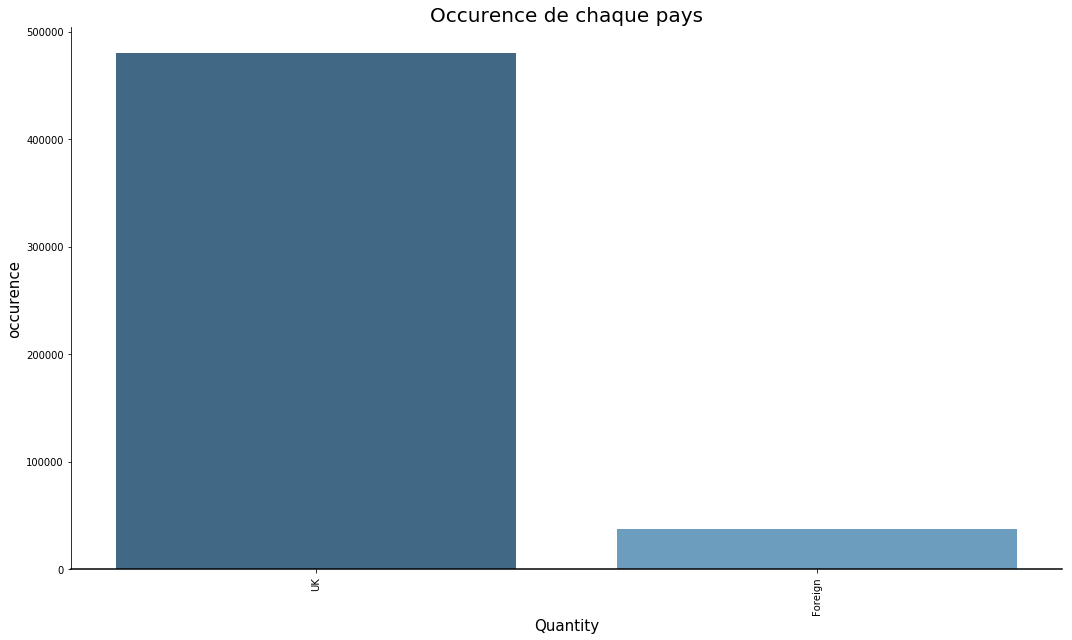

In [82]:
# visualiser les occurences de nos deux variables "pays"
valeurs = plot_value_counts('Country_bis',df=df)
# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)

# occurence en valeurs non manquantes
y1 = valeurs.iloc[:,1]
g = sns.barplot(x=valeurs.iloc[:,0], y=y1, palette='Blues_d', ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Occurence",fontsize=15)
# affiche uniquement un certain nombre de films en légende
plt.locator_params(axis='x', nbins=65)
#ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlabel("Quantity",fontsize=15)
ax1.set_ylabel("occurence",fontsize=15)
#plt.axis([0, 50, 0, 10000])

# Finalize the plot
g = sns.despine(bottom=True)
plt.xticks(rotation=90)
plt.title("Occurence de chaque pays",fontsize=20)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.savefig('pict_retard_jour_year.png', dpi=400)

In [83]:
# sauver les données

# save 
df.to_csv("fc_data.csv")